<a href="https://colab.research.google.com/github/xb24/Deep-Network-Models/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 6 and 7

**BME590.07: Deep Neural Network Models of the Brain**

_Duke University. Spring, 2022_.

This problem set was adapted from a lab exercise built by Scott Linderman at Stanford University and includes data from the [Baccus Lab](https://baccuslab.sites.stanford.edu/) (Stanford University).

# Environment Setup

In [ ]:
import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange
from copy import deepcopy
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.distributions import Poisson

import math
from IPython.display import HTML
import matplotlib.animation as animation

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

In [ ]:
#@title Pre-built helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

def plot_stimulus_weights(glm):
    num_neurons = glm.num_neurons
    max_delay = glm.max_delay

    fig, axs = plt.subplots(num_neurons, 3, figsize=(8, 4 * num_neurons),
                            gridspec_kw=dict(width_ratios=[1, 1.9, .1]))

    temporal_weights = from_t(glm.temporal_conv.weight[:, 0])
    bias = from_t(glm.temporal_conv.bias)
    spatial_weights = from_t(glm.spatial_conv.weight)
    spatial_weights = spatial_weights.reshape(num_neurons, 50, 50)

    # normalize and flip the spatial weights
    for n in range(num_neurons):
        # Flip if spatial weight peak is negative
        if np.allclose(spatial_weights[n].min(),
                    -abs(spatial_weights[n]).max()):
            spatial_weights[n] = -spatial_weights[n]
            temporal_weights[n] = -temporal_weights[n]

        # Normalize
        scale = np.linalg.norm(spatial_weights[n])
        spatial_weights[n] /= scale
        temporal_weights[n] *= scale

    # Set the same limits for each neuron
    vlim = abs(spatial_weights).max()
    ylim = abs(temporal_weights).max()

    for n in range(num_neurons):
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, temporal_weights[n])
        axs[n, 0].set_ylim(-ylim, ylim)
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, np.zeros(max_delay), ':k')
        if n < num_neurons - 1:
            axs[n, 0].set_xticklabels([])
        else:
            axs[n, 0].set_xlabel("$\Delta t$ [ms]")

        im = axs[n, 1].imshow(spatial_weights[n],
                              vmin=-vlim, vmax=vlim, cmap="RdBu")
        axs[n, 1].set_axis_off()
        axs[n, 1].set_title("neuron {}".format(n + 1))
        plt.colorbar(im, cax=axs[n, 2])


def plot_coupling_weights(glm):
    # Get the weights and flip them to get time after spike
    W = from_t(glm.coupling_conv.weight)
    W = W[:, :, ::-1]
    wlim = abs(W).max()
    dt = 10 * np.arange(W.shape[2])

    fig, axs = plt.subplots(num_neurons, num_neurons, figsize=(12, 12),
                            sharex=True, sharey=True)
    for i in range(num_neurons):
        for j in range(num_neurons):
            axs[i, j].plot(dt, 0 * dt, ':k')
            axs[i, j].plot(dt, W[i, j])
            axs[i, j].set_ylim(-wlim, wlim)
            axs[i, j].set_title("${} \\to {}$".format(j, i))

            if i == num_neurons - 1:
                axs[i, j].set_xlabel("$\Delta t$ [ms]")
    plt.tight_layout()

def plot_cnn_subunits_1(cnn):
    num_subunits = cnn.num_subunits_1
    max_delay = cnn.max_delay

    fig, axs = plt.subplots(num_subunits, 3, figsize=(8, 4 * num_subunits),
                            gridspec_kw=dict(width_ratios=[1, 1.9, .1]))

    temporal_weights = from_t(cnn.temporal_conv.weight[:, 0])
    bias = from_t(cnn.temporal_conv.bias)
    spatial_weights = from_t(cnn.spatial_conv.weight)
    spatial_weights = spatial_weights[:, 0, :, :]

    # normalize and flip the spatial weights
    for n in range(num_subunits):
        # Flip if spatial weight peak is negative
        if np.allclose(spatial_weights[n].min(),
                    -abs(spatial_weights[n]).max()):
            spatial_weights[n] = -spatial_weights[n]
            temporal_weights[n] = -temporal_weights[n]

        # Normalize
        scale = np.linalg.norm(spatial_weights[n])
        spatial_weights[n] /= scale
        temporal_weights[n] *= scale

    # Set the same limits for each neuron
    vlim = abs(spatial_weights).max()
    ylim = abs(temporal_weights).max()

    for n in range(num_subunits):
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, temporal_weights[n])
        axs[n, 0].set_ylim(-ylim, ylim)
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, np.zeros(max_delay), ':k')
        if n < num_subunits - 1:
            axs[n, 0].set_xticklabels([])
        else:
            axs[n, 0].set_xlabel("$\Delta t$ [ms]")

        im = axs[n, 1].imshow(spatial_weights[n],
                              vmin=-vlim, vmax=vlim, cmap="RdBu")
        axs[n, 1].set_axis_off()
        axs[n, 1].set_title("subunit 1,{}".format(n + 1))
        plt.colorbar(im, cax=axs[n, 2])

def plot_cnn_subunits2(cnn):
    cnn_filters_2 = from_t(cnn.layer2.weight)

    fig, axs = plt.subplots(cnn.num_subunits_2,
                            cnn.num_subunits_1,
                            figsize=(4 * cnn.num_subunits_2,
                                    4 * cnn.num_subunits_1),
                            sharex=True, sharey=True)
    vlim = abs(cnn_filters_2).max()
    for i in range(cnn.num_subunits_2):
        for j in range(cnn.num_subunits_1):
            axs[i, j].imshow(cnn_filters_2[i, j],
                            vmin=-vlim, vmax=vlim, cmap="RdBu")

            axs[i, j].set_title('subunit 1,{} $\\to$ 2,{}'.format(j+1,i+1))


In [ ]:
#@title Implemented `train_model` function (run this cell!)

# Regularize the weights of the CNN
def cnn_regularizer(model, alpha=1e-3):
    """
    Implement an \ell_2 penalty on the norm of the model weights,
    as described above.

    model: CNN instance
    alpha: scaling parameter for the \ell_2 penalty.
    """
    reg = (
        torch.norm(model.spatial_conv.weight)**2 +
        torch.norm(model.temporal_conv.weight)**2 +
        torch.norm(model.layer2.weight)**2 +
        torch.norm(model.layer3.weight)**2
        )
    reg = alpha*reg/4
    return reg

def train_model(model,
                train_dataset,
                val_dataset,
                objective,
                regularizer=None,
                num_epochs=100,
                lr=0.1,
                momentum=0.9,
                lr_step_size=25,
                lr_gamma=0.9):
    # progress bars
    pbar = trange(num_epochs)
    pbar.set_description("---")
    inner_pbar = trange(len(train_dataset))
    inner_pbar.set_description("Batch")

    # data loaders for train and validation
    train_dataloader = DataLoader(train_dataset, batch_size=1)
    val_dataloader = DataLoader(val_dataset, batch_size=1)
    dataloaders = dict(train=train_dataloader, val=val_dataloader)

    # use standard SGD with a decaying learning rate
    optimizer = optim.SGD(model.parameters(),
                          lr=lr,
                          momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer,
                                    step_size=lr_step_size,
                                    gamma=lr_gamma)

    # Keep track of the best model
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    for epoch in pbar:
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                inner_pbar.reset()
            else:
                model.eval()

            # track the running loss over batches
            running_loss = 0
            running_size = 0
            for datapoint in dataloaders[phase]:
                stim_t = datapoint['stimulus'].squeeze(0)
                spikes_t = datapoint['spikes'].squeeze(0)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()
                        # compute the model output and loss
                        output_t = model(stim_t, spikes_t)
                        loss_t = objective(output_t, spikes_t)
                        # only add the regularizer in the training phase
                        if regularizer is not None:
                            loss_t += regularizer(model)

                        # take the gradient and perform an sgd step
                        loss_t.backward()
                        optimizer.step()
                    inner_pbar.update(1)
                else:
                    # just compute the loss in validation
                    output_t = model(stim_t, spikes_t)
                    loss_t = objective(output_t, spikes_t)

                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())

        # Update the learning rate
        scheduler.step()

        # Update the progress bar
        pbar.set_description("Epoch {:03} Train {:.4f} Val {:.4f}"\
                             .format(epoch, train_losses[-1], val_losses[-1]))
        pbar.update(1)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

# **Problem Set 6:** Explore the data, complete the code for running your artifical retina, and train/test it on both videos.

## Load and explore the data (always explore and visualize your data!)

- Each HDF5 file file contains a `train` and `test` group.
- Each group contains:
    - `time`: length `frames` array of timestamps
    - `stimulus`: a `frames x 50 x 50` video taken at ~100Hz
    - `response`: a group with
        - `binned`: `cells x frames` array of spike counts (for the training data) or rates (for the test data) in each bin



In [ ]:
%%capture
!wget -nc https://www.dropbox.com/s/gmgus2rm4sks6b8/whitenoise.h5
!wget -nc https://www.dropbox.com/s/gj8jf50v7dzy4ew/naturalscene.h5

In [ ]:
# Load the natural scene data. Later on, you will need to load the white noise data similarly
f = h5py.File("naturalscene.h5", mode='r')
frame_rate = 100
times = f['train']['time'][:]
stimulus = f['train']['stimulus'][:]
spikes = f['train']['response']['binned'][:].T
test_times = f['test']['time'][:]
test_stimulus = f['test']['stimulus'][:] / 128
test_rates = f['test']['response']['binned'][:, :-1].T

# Get the size of the training data
num_frames, height, width = stimulus.shape
_, num_neurons = spikes.shape

### **TODO** Problem 6a: Visualize the spike trains.

 - Plot the first 5 seconds of `spikes` for each neuron (from the `train` dataset in response to white noise)  

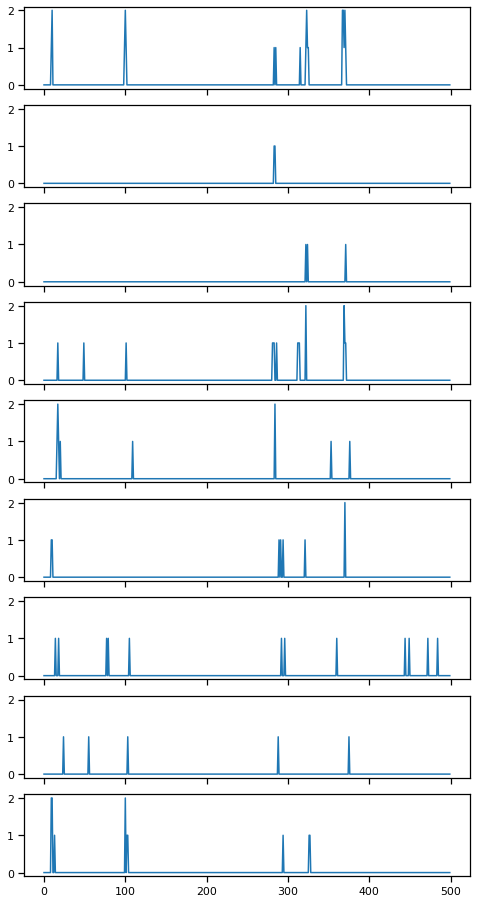

In [ ]:
fig, axs = plt.subplots(num_neurons,1, figsize=(8, 16), sharex=True, sharey=True)
for i in range(0,num_neurons):
  axs[i].plot(spikes[0:500, i])

### **TODO** Problem 6b: Visualize the movies

 - Adapt the code from [this Colab notebook](https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/A.03-Animation-in-Jupyter-Notebooks.ipynb) to display the video in a cell.

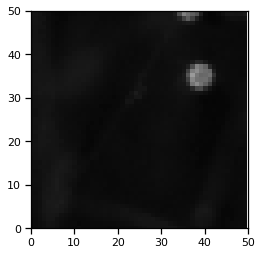

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim((0, 50))
ax.set_ylim((0, 50))

im = ax.imshow(stimulus[0,:,:], cmap='gray')


def init():
    im.set_data(stimulus[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = stimulus[i,:,:]
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=10, blit=True)

HTML(anim.to_html5_video())

## Create PyTorch Datasets containing the stimuli and the spikes.
The code below will split the training stimulus and spikes into batches of length 1000 frames (10 seconds of data). Then we'll randomly assign 20% of the batches to a validation dataset.

In [ ]:
#@title Pre-built helper functions for making PyTorch datasets (run this cell!)
class RGCDataset(Dataset):
  def __init__(self, stimulus, spikes):
      self.stimulus = stimulus
      self.spikes = spikes

  def __len__(self):
      return self.stimulus.shape[0]

  def __getitem__(self, idx):
      # Binarize the stimulus, move it and the spikes to the GPU,
      # and package into a dictionary
      return dict(stimulus=to_t(self.stimulus[idx]) / 128.0,
                  spikes=to_t(self.spikes[idx]))

def make_datasets(batch_size=1000):
    n_batches = num_frames // batch_size
    batched_stimulus = stimulus[:n_batches * batch_size]
    batched_stimulus = batched_stimulus.reshape(n_batches, batch_size, height, width)
    batched_spikes = spikes[:n_batches * batch_size]
    batched_spikes = batched_spikes.reshape(n_batches, batch_size, num_neurons)

    # Split into train and validation
    train_stimulus, val_stimulus, train_spikes, val_spikes = \
        train_test_split(batched_stimulus,
                        batched_spikes,
                        train_size=0.8,
                        random_state=0)


    train_dataset = RGCDataset(train_stimulus, train_spikes)
    val_dataset = RGCDataset(val_stimulus, val_spikes)
    return train_dataset, val_dataset

train_dataset, val_dataset = make_datasets()

# CNN model

<center>
<img src=https://github.com/slinderman/stats320/raw/main/assets/cnn.png width=500>
</center>
<small><it>Image credit: McIntosh et al (NeurIPS, 2016).</it></small>

We'll implement a convolutional neural network like the one proposed in McIntosh et al (2016). We'll make some slight modifications, though, so that the model doesn't take so long to train.


## **TODO** Problem 6c: Implement the retinal CNN

Implement the following model:
1. **Apply spatiotemporal filter to the video:**
  
  a. First convolve with 2D receptive fields of size `rf_size_1` and `num_subunits_1` output channels. You do not need to pad the edges since the neurons respond primarily to the center of the video. Your output should be `T x N1 x H1 x W1` where `T` is the number of frames, `N1` is the number of subunits (i.e. output channels), and `H1,W1` are the height and width after 2D convolution without padding.
  
  b. Then convolve each subunit and pixel with a temporal filter, to get another `T x N1 x H1 x W1` output.

  c. Apply a rectifying nonlinearity (`F.relu`).

2. **Spatial convolution and mixing**

  a. Apply a spatial convolution of size `rf_size_2` with `num_subunits_2` output channels. This layer mixes the subunits from the first layer to obtain a representation that is, hopefully, somewhat similar to that of intermediate cells in the retina.
  
  b. Apply another rectifying nonlinearity (`F.relu`). The output should be `T x N2 x H2 x W2` where `N2` is the number of subunits in the second layer and `H2,W2` are the size of the image after convolution without padding.

3. **Predict expected spike counts**

  a. Apply a linear read-out to the `N2 x H2 x W2` representation and pass through an exponential function to obtain a `T x N` tensor of expected spike counts, where `N` is the number of neurons.

### The Poisson loss

The output from your retinal CNN is a time series of spike counts. You should remember from earlier in the semester that these spike counts can be modeled using the Poisson distribution.

Thus the way we train our model is to maximize the log of the **likelihood** that the observed spike counts in each frame (the ones in our training data) came from a Poisson distribution with mean equal to the predicted spike rate in each frame (the output from the network). To use SGD for this, we formulate this as minimizing the negative log likelihood (equivalent to maximizing the log likelihood). The log of the likehood is used because it is more computationally tractable.

The function below computes the average negative log likelihood of the spikes (taking the mean over output RGC neurons and frames) given the rates (`rates_t`) output by the model.

\begin{align}
\mathcal{L} = -\frac{1}{NT} \sum_{n=1}^N \sum_{t=1}^T \log \mathrm{Po}(y_{nt} \mid \lambda_{nt})
\end{align}
where $\lambda_{nt}$ denotes the rates output by the model.

### **TODO** Problem 6c: Implement the log Poisson loss.

It's just one line. Do not just call the PyTorch implementation. (*Hint: However, the PyTorch documentation does tell you exactly what the one liner is, as do my lecture notes.*)

In [ ]:
from re import match
def poisson_loss(rate_t, spikes_t):
    """Compute the average negative log-likelihood under a
    Poisson spiking model.

    rate_t:  T x N array of expected spike counts
    spikes_t: T x N array of integer spikes
    returns: average negative log likelihood (mean over all spikes)
    """
    ###
    # YOUR CODE BELOW
    #

    nll = rate_t - (spikes_t*torch.log(rate_t))

    # END YOUR CODE
    ###
    avg_nll = nll.mean()
    return avg_nll

### **TODO** Problem 6c: Implement the retinal CNN by filling in the code missing below.

In [ ]:
class CNN(nn.Module):
    def __init__(self,
                 num_neurons=num_neurons,
                 height=height,
                 width=width,
                 rf_size_1=21,
                 rf_size_2=15,
                 max_delay=40,
                 num_subunits_1=4,
                 num_subunits_2=4,
                 initial_bias=0.05,
                 mean_function=torch.exp):

        super(CNN, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.rf_size_1 = rf_size_1
        self.num_subunits_1 = num_subunits_1
        self.rf_size_2 = rf_size_2
        self.num_subunits_2 = num_subunits_2
        self.mean_function = mean_function

        ###
        # YOUR CODE BELOW
        #
        self.spatial_conv = nn.Conv2d(1, num_subunits_1, kernel_size=(rf_size_1, rf_size_1), stride=(1, 1), padding='valid')
        self.temporal_conv = nn.Conv1d(num_subunits_1, num_subunits_1, kernel_size=max_delay, stride=1, padding=max_delay-1)

        # Spatial convolution over the subunits in layer 1
        self.layer2 = nn.Conv2d(num_subunits_1, num_subunits_2, kernel_size=(rf_size_2, rf_size_2), stride=(1, 1), padding='valid') #output = 4*16*16

        # Fully connected layer at the end
        self.layer3 = nn.Linear(num_subunits_2*16*16, 1*num_neurons, bias=True) #16*16

        # END YOUR CODE
        ###

        # Initialize the bias (THIS LINE DOES NOT NEED TO BE MODIFIED)
        torch.nn.init.constant_(self.layer3.bias, np.log(initial_bias))

    def forward(self, stimulus, spikes=None):
        """
        stimulus: num_frames x height x width
        spikes: num_frames x num_neurons (unused by this model)

        returns: num_frames x num_neurons tensor of expected spike counts
        """
        ###
        # YOUR CODE BELOW
        #
        x = stimulus.unsqueeze(1)
        # MORE CODE
        x = self.spatial_conv(x).reshape(x.shape[0],4,-1).permute(2,1,0)
        x = self.temporal_conv(x).permute(2,1,0)
        x = x[:-(self.max_delay-1)]
        x = F.relu(x).reshape(-1,self.num_subunits_1,30,30)
        x = self.layer2(x)
        x = F.relu(x).reshape(x.shape[0],1024)
        x = self.layer3(x)
        x = torch.exp(x)

        # END YOUR CODE
        ###

        # The small offset applied here prevents issues with the subsequent
        # log applied in the loss function.
        # (THIS LINE DOES NOT NEED TO BE MODIFIED)
        return 1e-4 + x

def check_model_outputs(model):
    out_t = model(train_dataset[0]['stimulus'],
                  train_dataset[0]['spikes'])
    assert out_t.shape == train_dataset[0]['spikes'].shape
    assert torch.all(out_t > 0)

torch.manual_seed(0)
cnn = CNN().to(device)
check_model_outputs(cnn)

## Fit the CNN model

In [ ]:
torch.manual_seed(0)
cnn = CNN().to(device)

print("Fitting the CNN model. This should take about 12 minutes.")
train_losses, val_losses = \
    train_model(cnn,
                train_dataset,
                val_dataset,
                poisson_loss,
                cnn_regularizer,
                num_epochs=100)

# train_losses, val_losses = \
#     train_model(cnn,
#                 train_dataset,
#                 val_dataset,
#                 torch.nn.functional.poisson_nll_loss,
#                 cnn_regularizer,
#                 num_epochs=100)


Fitting the CNN model. This should take about 12 minutes.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

## Plot loss curves to see how well training went

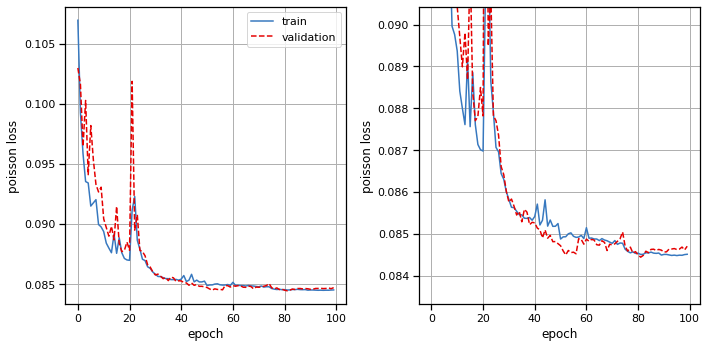

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[10])
axs[1].grid(True)

plt.tight_layout()

## Plot the subunit weights for the first layer of the CNN

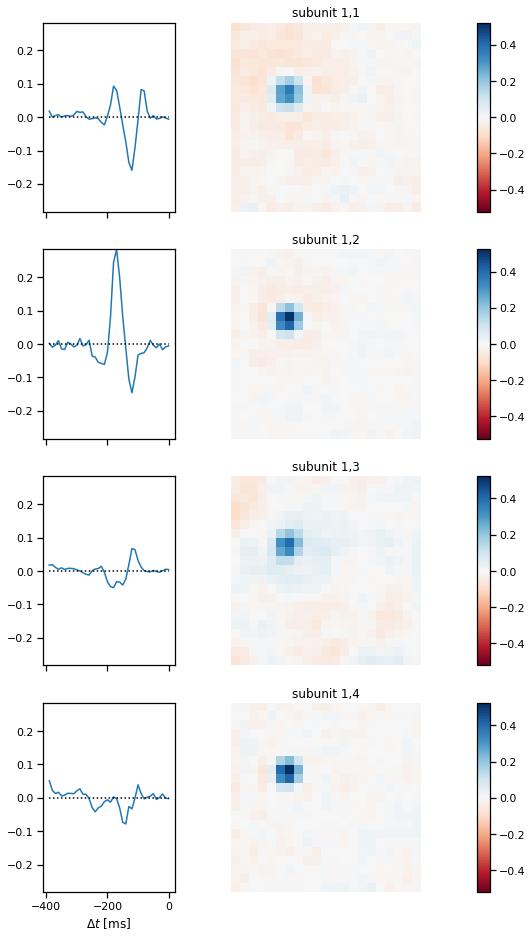

In [ ]:
# This will run using the helper code at the top of the notebook. No need to change anything
plot_cnn_subunits_1(cnn)

## Plot the spatial weights for the second layer of subunits.

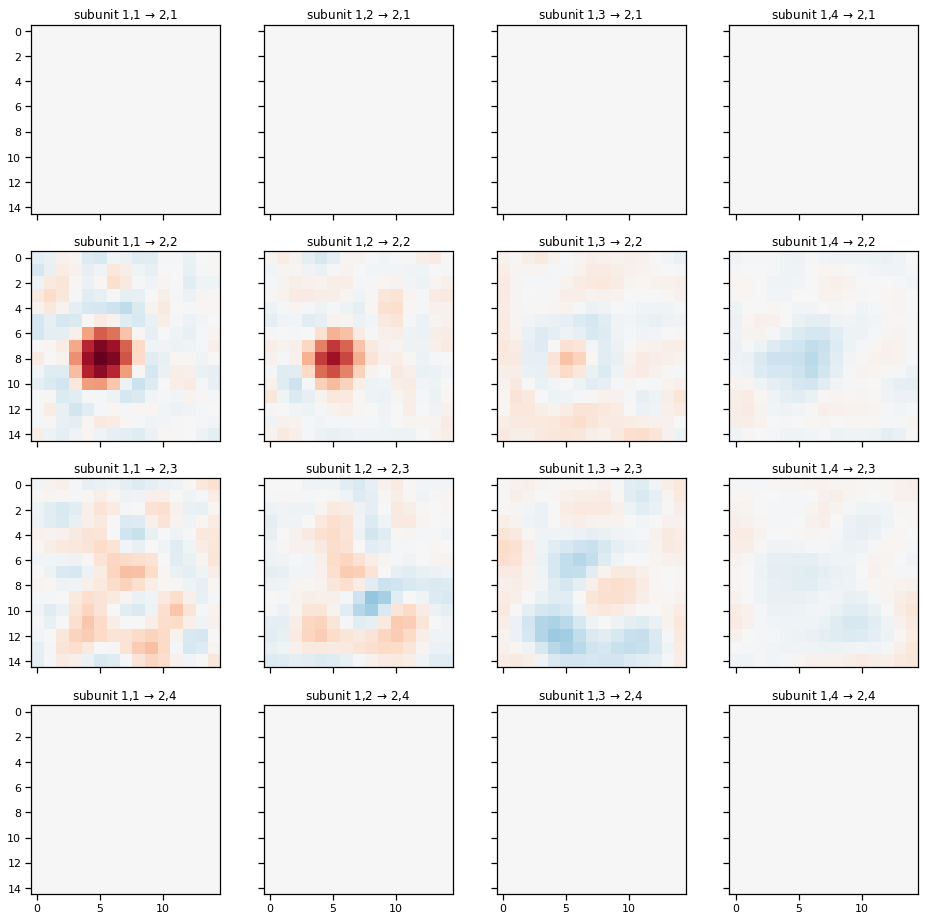

In [ ]:
# This will run using the helper code at the top of the notebook. No need to change anything
plot_cnn_subunits2(cnn)

### **TODO** Problem 6d: Predict firing rates on test video

 - Run the test video through your model and plot the predicted firing rates on top of the real firing rate trace.
 - Quantify the error using a metric of your choice and justify your choice).

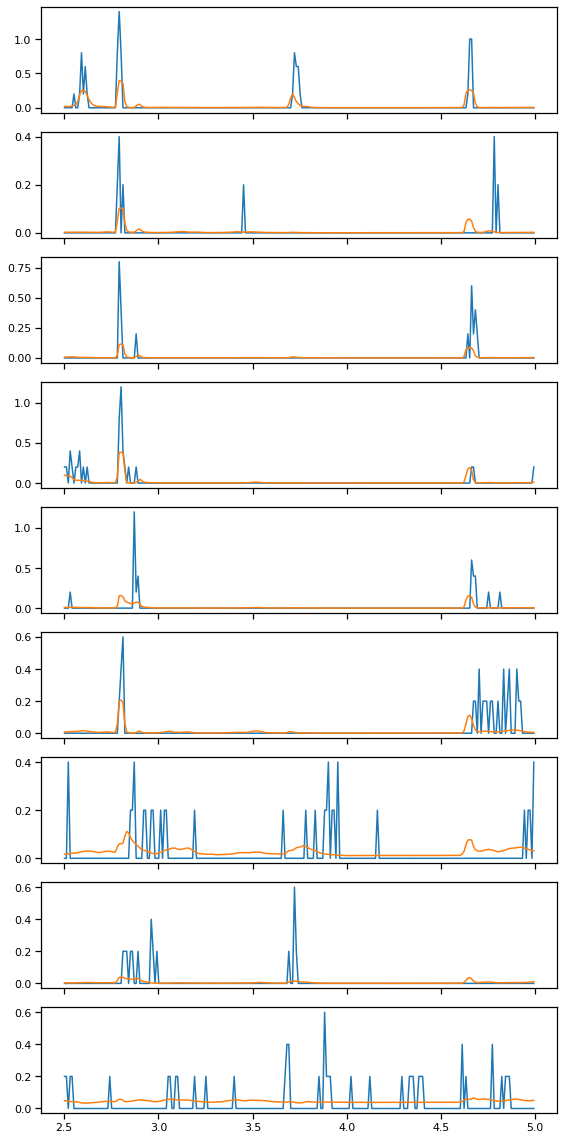

In [ ]:
# Move the test stimulus and measured rates to the GPU
test_stimulus_t = to_t(test_stimulus)
test_rates_t = to_t(test_rates)

###
# YOUR CODE BELOW
#
cnn_test_rates = from_t(cnn(test_stimulus_t))

# Plot a slice of the true and predicted firing rates
slc = slice(250, 500)
fig, axs = plt.subplots(num_neurons, 1, figsize=(8, 16), sharex=True)
for n in range(num_neurons):
  axs[n].plot(test_times[slc], test_rates[slc, n])
  axs[n].plot(test_times[slc], cnn_test_rates[slc, n])


# END YOUR CODE
###
plt.tight_layout()

In [ ]:
# Quantify the error using MSE
mse = nn.MSELoss()
er_mse = mse(test_rates_t, to_t(cnn_test_rates))
er_mse

tensor(0.0080, device='cuda:0')

### **TODO** Problem 6e: Compare the test performance for a model trained on natural scences vs. white noise
 - Train and test a model on the white noise data
 - Compare the performance between models using the error metric you used in Problem 1d.
 - Discuss your results. Do you see differences? If so, why might they be different?

In [ ]:
# Load the natural scene data. Later on, you will need to load the white noise data similarly
f = h5py.File("whitenoise.h5", mode='r')
frame_rate = 100
times = f['train']['time'][:]
stimulus = f['train']['stimulus'][:]
spikes = f['train']['response']['binned'][:].T
test_times = f['test']['time'][:]
test_stimulus = f['test']['stimulus'][:] / 128
test_rates = f['test']['response']['binned'][:, :-1].T

# Get the size of the training data
num_frames, height, width = stimulus.shape
_, num_neurons = spikes.shape

In [ ]:
train_dataset, val_dataset = make_datasets()

In [ ]:
class CNN(nn.Module):
    def __init__(self,
                 num_neurons=num_neurons,
                 height=height,
                 width=width,
                 rf_size_1=21,
                 rf_size_2=15,
                 max_delay=40,
                 num_subunits_1=4,
                 num_subunits_2=4,
                 initial_bias=0.05,
                 mean_function=torch.exp):

        super(CNN, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.rf_size_1 = rf_size_1
        self.num_subunits_1 = num_subunits_1
        self.rf_size_2 = rf_size_2
        self.num_subunits_2 = num_subunits_2
        self.mean_function = mean_function

        ###
        # YOUR CODE BELOW
        #
        self.spatial_conv = nn.Conv2d(1, num_subunits_1, kernel_size=(rf_size_1, rf_size_1), stride=(1, 1), padding='valid')
        self.temporal_conv = nn.Conv1d(num_subunits_1, num_subunits_1, kernel_size=max_delay, stride=1, padding=max_delay-1)

        # Spatial convolution over the subunits in layer 1
        self.layer2 = nn.Conv2d(num_subunits_1, num_subunits_2, kernel_size=(rf_size_2, rf_size_2), stride=(1, 1), padding='valid') #output = 4*16*16

        # Fully connected layer at the end
        self.layer3 = nn.Linear(num_subunits_2*16*16, 1*num_neurons, bias=True) #16*16

        # END YOUR CODE
        ###

        # Initialize the bias (THIS LINE DOES NOT NEED TO BE MODIFIED)
        torch.nn.init.constant_(self.layer3.bias, np.log(initial_bias))

    def forward(self, stimulus, spikes=None):
        """
        stimulus: num_frames x height x width
        spikes: num_frames x num_neurons (unused by this model)

        returns: num_frames x num_neurons tensor of expected spike counts
        """
        ###
        # YOUR CODE BELOW
        #
        x = stimulus.unsqueeze(1)
        # MORE CODE
        x = self.spatial_conv(x).reshape(x.shape[0],4,-1).permute(2,1,0)
        x = self.temporal_conv(x).permute(2,1,0)
        x = x[:-(self.max_delay-1)]
        x = F.relu(x).reshape(-1,self.num_subunits_1,30,30)
        x = self.layer2(x)
        x = F.relu(x).reshape(x.shape[0],1024)
        x = self.layer3(x)
        x = torch.exp(x)

        # END YOUR CODE
        ###

        # The small offset applied here prevents issues with the subsequent
        # log applied in the loss function.
        # (THIS LINE DOES NOT NEED TO BE MODIFIED)
        return 1e-4 + x

def check_model_outputs(model):
    out_t = model(train_dataset[0]['stimulus'],
                  train_dataset[0]['spikes'])
    assert out_t.shape == train_dataset[0]['spikes'].shape
    assert torch.all(out_t > 0)

torch.manual_seed(1)
cnn_wn = CNN().to(device)
check_model_outputs(cnn_wn)

In [ ]:
torch.manual_seed(1)
cnn_wn = CNN().to(device)

print("Fitting the CNN model. This should take about 12 minutes.")
train_losses, val_losses = \
    train_model(cnn_wn,
                train_dataset,
                val_dataset,
                poisson_loss,
                cnn_regularizer,
                num_epochs=100)

Fitting the CNN model. This should take about 12 minutes.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

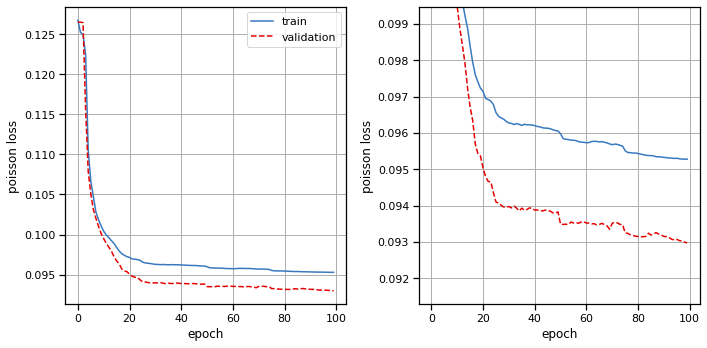

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[10])
axs[1].grid(True)

plt.tight_layout()

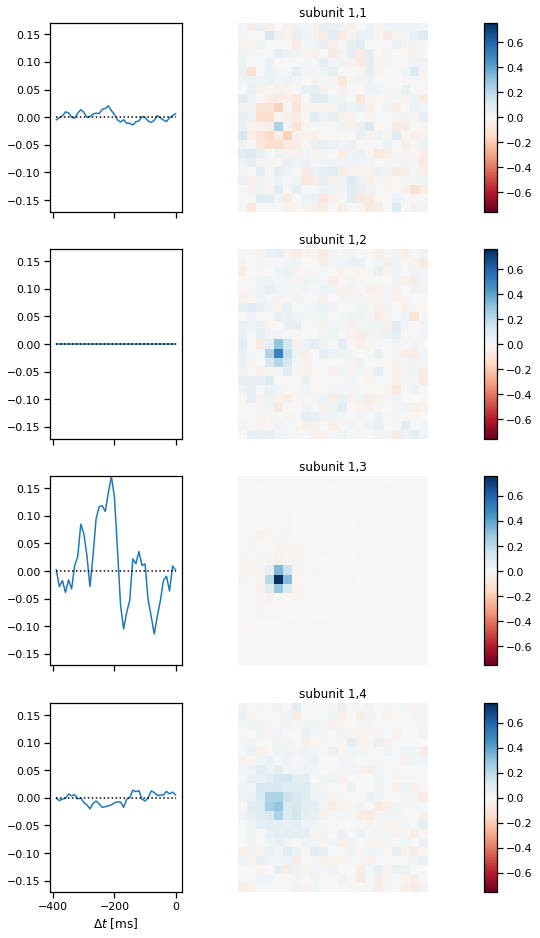

In [ ]:
# This will run using the helper code at the top of the notebook. No need to change anything
plot_cnn_subunits_1(cnn_wn)

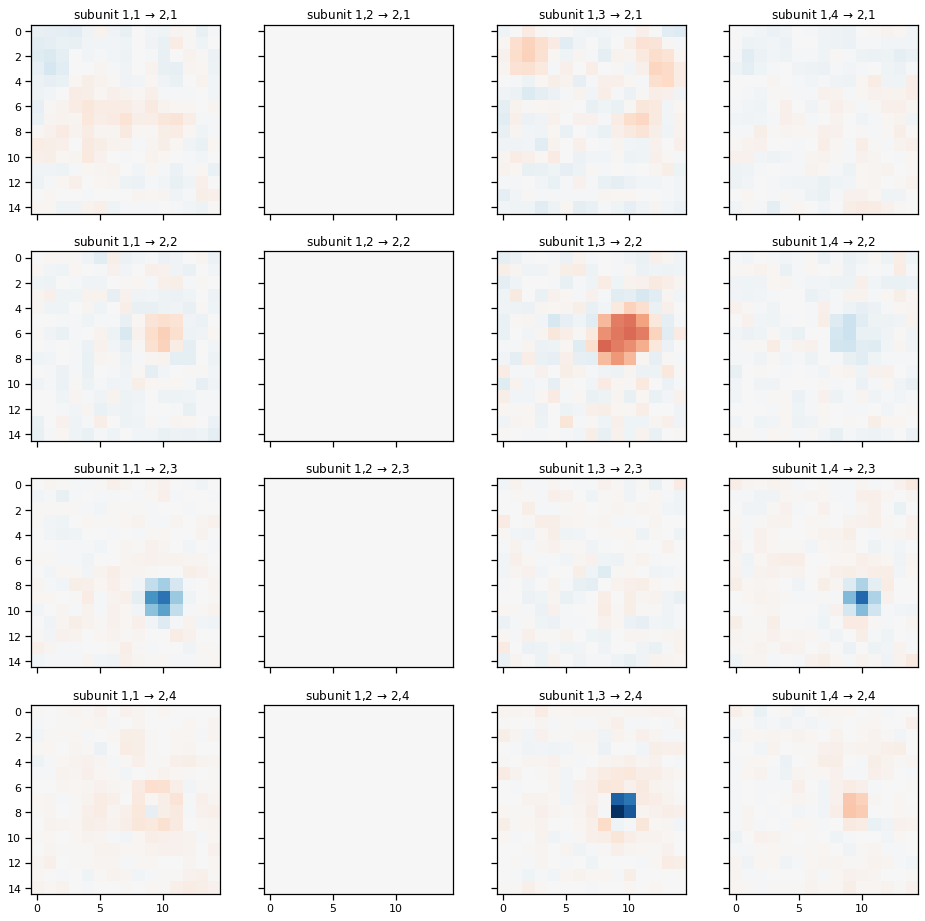

In [ ]:
# This will run using the helper code at the top of the notebook. No need to change anything
plot_cnn_subunits2(cnn_wn)

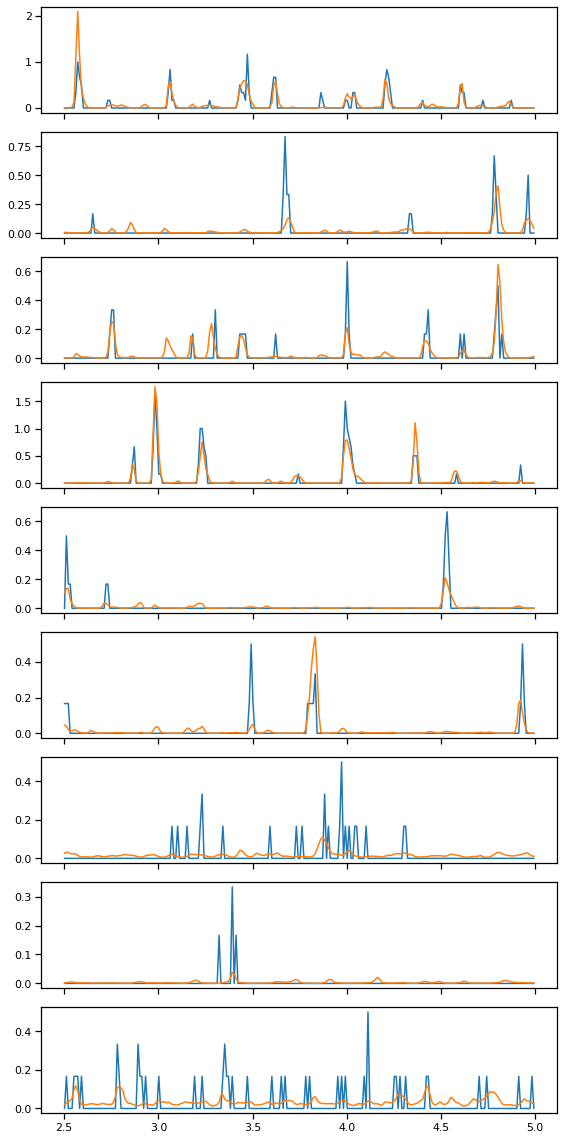

In [ ]:
# Move the test stimulus and measured rates to the GPU
test_stimulus_t = to_t(test_stimulus)
test_rates_t = to_t(test_rates)

###
# YOUR CODE BELOW
#
cnn_test_rates = from_t(cnn_wn(test_stimulus_t))

# Plot a slice of the true and predicted firing rates
slc = slice(250, 500)
fig, axs = plt.subplots(num_neurons, 1, figsize=(8, 16), sharex=True)
for n in range(num_neurons):
  axs[n].plot(test_times[slc], test_rates[slc, n])
  axs[n].plot(test_times[slc], cnn_test_rates[slc, n])


# END YOUR CODE
###
plt.tight_layout()

In [ ]:
er_mse = mse(test_rates_t, to_t(cnn_test_rates))
er_mse

tensor(0.0063, device='cuda:0')

Compare the performance between models using the error metric you used in Problem 1d.

*I used MSE as the error metric for both models. The model trained with white noise video yields a lower MSE, indicating a better match, or alignment. Consistent with this, we can see that the predicted firing rates align better to the real firing rate trace when the model is trained with white noise dataset. However, using MSE as the error metric bias towards the predicted amplitude of the neuron firing, leaving the temporal precision of occrance underrepresented.*

Discuss your results. Do you see differences? If so, why might they be different?

*Comparing the results generated by two models, I saw the difference in the training and validation curves (loss), subunit 1 plots, subunit 2 plots and prediction-real trace alignment. Based on the loss and subunit plots, we can see that our CNN works better on natural scene data. This is because, when using white noise as the training dataset, we are training the CNN with minimally informative data. Hence, we would see a larger loss for validation compared to the loss we got after training. Although the prediction-real trace alignment looks better for white noise, it may be due to the shallowness of our CNN.*

# **Problem Set 7:** Use your models to investigate the emergence of a retinal computation.



## **TODO** Problem 7a: Design and use a stimulus to test the emergence of retinal functional properties.

Write code to see whether your model exhibits one of the following properties from [Maheswaranathan et al.](https://ganguli-gang.stanford.edu/pdf/18.DeepRetina.pdf) (or **two** of the following for extra credit). I have ranked them from easiest to hardest to implement (in my opinion).

 - CNN subunits with ON/OFF sustained and transient responses to flashed stimuli (see Maheswaranathan et al. *Figure 2*.)
 - CNN RGC Latency coding for the brightness of flashed stimuli
 - CNN RGC responses to an omitted stimulus in a train of flashed stimuli
 - Motion anticipation to moving bars in CNN RGCs

In [ ]:
onoff = torch.zeros(1000, 50, 50)
for i in range(0,250):
  onoff[i] = 1
for i in range(750, 1000):
  onoff[i] = 1

In [ ]:
activation = {}
def get_output(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [ ]:
cnn.temporal_conv.register_forward_hook(get_output('temporal_conv'))
response = cnn(to_t(onoff))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


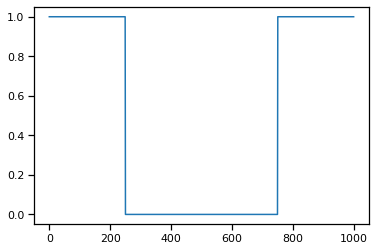

In [ ]:
# Stimulus
plt.plot(onoff[:,0,0])

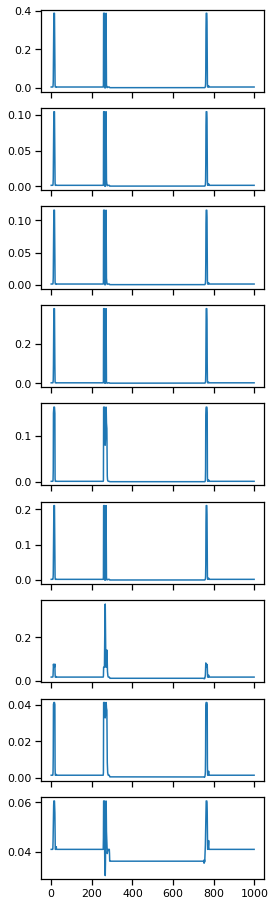

In [ ]:
fig, axs = plt.subplots(response.shape[1], 1, figsize=(4, 16), sharex=True)
for n in range(response.shape[1]):
  axs[n].plot(from_t(response[:, n]))

## TODO Problem 7b: Compare the white noise to the natural scenes model

 - For the property you investigated, write code to test whether both of your models exhibit it.
 - Dicuss your results. Do you see differences? If so, why might they be different?

In [ ]:
cnn_wn.temporal_conv.register_forward_hook(get_output('temporal_conv'))
response_wn = cnn_wn(to_t(onoff))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


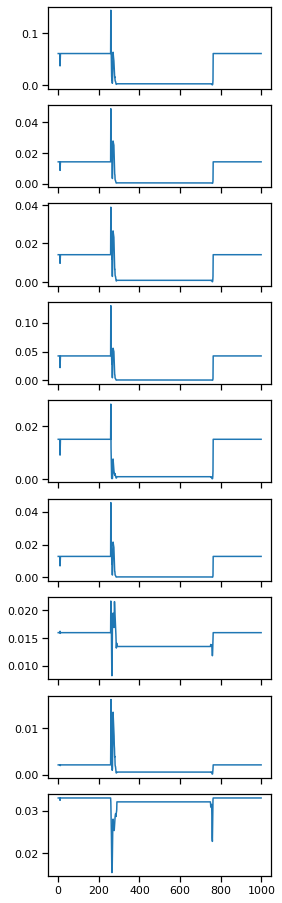

In [ ]:
fig, axs = plt.subplots(response_wn.shape[1], 1, figsize=(4, 16), sharex=True)
for n in range(response_wn.shape[1]):
  axs[n].plot(from_t(response_wn[:, n]))

Dicuss your results. Do you see differences? If so, why might they be different?

*Based on the plots above, both models exhibit some level of sustained and transient responses to ON/OFF/ON flashed stimuli. However, the model trained with natural scene data better captures the first transient response to ON flashed stimulus and the third transient response to OFF-to-ON flashed stimuli. On the other hand, the model trained with white nois data sometimes only captures the second transient repsone to ON-to-OFF flashed stimuli. Additionaly, the model trained with white noise data exhibits a more obvious difference between the sustained response level when the stimulus is ON and OFF. Specifically, plots above show that the sustained response is lower when the stimulus is off and higher when the stimulus is on, which has not been sufficiently captured by the model trained with natural scene data.*

*Such difference in the predicted sustained and transient responses is intuitively agreed with how we trained the models. Specifically, model trained with white noise is expected to be better at predicting sustained response to static stimulus. (Here, when the light is kept ON or OFF). On the other hand, model trained with nature scene is expected to be better at predicting transient response to changing stimulus. (Here, when the light is shifted from ON to OFF or the other way around)*